<a href="https://colab.research.google.com/github/VDidyk/AI/blob/master/module3/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0_%D0%B4%D0%B5%D1%80%D0%B5%D0%B2%D0%B0_%D1%80%D1%96%D1%88%D0%B5%D0%BD%D1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [38]:
df = pd.read_csv("https://raw.githubusercontent.com/HalyshAnton/IT-Step-Pyton-AI/main/module3/data/Used%20Car%20Dataset.csv", index_col="Unnamed: 0")
df.drop(columns=['car_name', 'registration_year', 'ownsership', 'transmission'], inplace=True)

Дані про ціни вживаних автомобілів у Індії
* car_name - назва авто у форматі 'рік компанія основна назва'
* registration_year - місяць та рік реєстрації
* ownsership - кількість власників у форматі 'Second owner'
* transmission - тип коробки передач
* insurance_validity - тип страховки
* fuel_type - вид палива
* seats - кількість сидінь
* kms_driven - пробіг
* manufacturing_year - рік виробництва, має тип object, потрібно застосувати astype(int)
* mileage(kmpl) - скільки кілометрів проїде за літр палива
* engine(cc) - об'єм двигуна у мл
* max_power(bhp) - потужність у кінських силах
* torque(Nm) - крутний момент двигуна
* price(in lakhs) - ціна у сто тисяч рупій

[Повний аналіз даних](https://www.kaggle.com/code/abdelrasoul/used-cars-prices-prediction)

In [39]:
df.head()

,insurance_validity,fuel_type,seats,kms_driven,manufacturing_year,mileage(kmpl),engine(cc),max_power(bhp),torque(Nm),price(in lakhs)
0,Comprehensive,Petrol,5,56000,2017,7.81,2996.0,2996.0,333.0,63.75
1,Comprehensive,Petrol,5,30615,2020,17.40,999.0,999.0,9863.0,8.99
2,Comprehensive,Diesel,5,24000,2018,20.68,1995.0,1995.0,188.0,23.75
3,Comprehensive,Petrol,5,18378,2019,16.50,1353.0,1353.0,13808.0,13.56
4,Comprehensive,Petrol,5,44900,2019,14.67,1798.0,1798.0,17746.0,24.00


In [40]:
df = df[['fuel_type', 'kms_driven', 'engine(cc)', 'price(in lakhs)']]
df.head()

,fuel_type,kms_driven,engine(cc),price(in lakhs)
0,Petrol,56000,2996.0,63.75
1,Petrol,30615,999.0,8.99
2,Diesel,24000,1995.0,23.75
3,Petrol,18378,1353.0,13.56
4,Petrol,44900,1798.0,24.00


# Завдання 1
Очистіть дані від викидів(лише `price`), розділіть на тренувальну та тестову чатини

In [41]:
def remove_outliers(df, column_name):
  column = df[column_name]

  q1 = column.quantile(q=0.25)
  q3 = column.quantile(q=0.75)

  iqr = q3 - q1

  lower = q1 - 1.5*iqr
  upper = q3 + 1.5*iqr

  mask = (column >= lower) & (column <= upper)

  return df[mask]


df = remove_outliers(df, "price(in lakhs)")


In [42]:
df.dropna(subset=["price(in lakhs)"], inplace=True)

In [43]:
y = df['price(in lakhs)']
X = df.drop(columns='price(in lakhs)')

In [44]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    random_state=42)

# Завдання 2
Створіть Pipeline для обробки даних

In [45]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

num_columns = X.select_dtypes(include="number").columns

num_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median"))])

In [46]:
cat_columns = X.select_dtypes(include="object").columns
cat_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder())
    ])

# Завдання 3
Створіть остаточну модель та натренуйте її

In [47]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_columns),
        ("cat", cat_transformer, cat_columns),
    ]
)

preprocessor


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 Index(['kms_driven', 'engine(cc)'], dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder', OneHotEncoder())]),
                                 Index(['fuel_type'], dtype='object'))])

In [62]:
from sklearn.linear_model import LinearRegression
from sklearn import tree

def create_model(depth):
  return Pipeline(
    [
        ("prep", preprocessor),
        ("model", tree.DecisionTreeRegressor(max_depth=depth))
    ]
  )

model = create_model(4)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
model

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['kms_driven', 'engine(cc)'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  Index(['fuel_type'], dtype='object'))])),
                ('model', DecisionTreeRegressor(max_depth=4))])

# Завдання 4
Виведіть основні метрики моделі

In [64]:
from sklearn import metrics

def get_metrics(y_true, y_pred, name="model"):
  df = pd.DataFrame()

  df.loc["MAE", name] = metrics.mean_absolute_error(y_true, y_pred)
  df.loc["RMSE", name] = metrics.mean_squared_error(y_true, y_pred) ** 0.5
  df.loc["R2", name] = metrics.r2_score(y_true, y_pred)

  return df.round(2)

all_metrics = pd.DataFrame()

all_metrics["train"] = get_metrics(y_train, model.predict(X_train))
all_metrics["test"] = get_metrics(y_test, y_pred)

all_metrics

,train,test
MAE,2.70,3.04
RMSE,4.12,4.72
R2,0.67,0.57


# Завдання 5
Змініть параметри моделі та попробуйте покращити результат

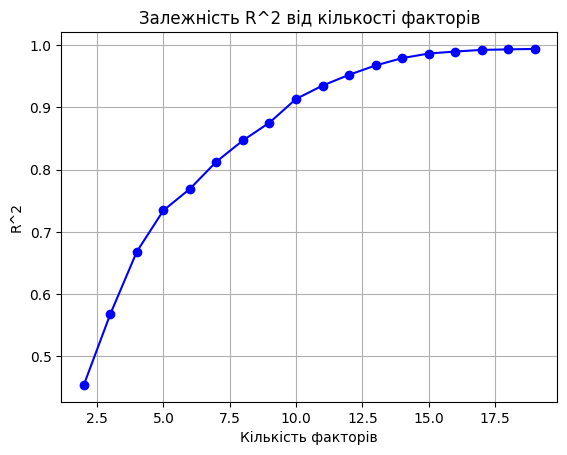

In [75]:
import matplotlib.pyplot as plt

r2 = []

for i in range(2,20):
  model = create_model(i)
  model.fit(X_train, y_train)
  y_pred= model.predict(X_train)

  r2.append((i,metrics.r2_score(y_train, y_pred)))

X, Y = zip(*r2)

plt.plot(X, Y, marker='o', linestyle='-', color='b')
plt.title('Залежність R^2 Train від кількості факторів')
plt.xlabel('Кількість факторів')
plt.ylabel('R^2')
plt.grid(True)

plt.show()

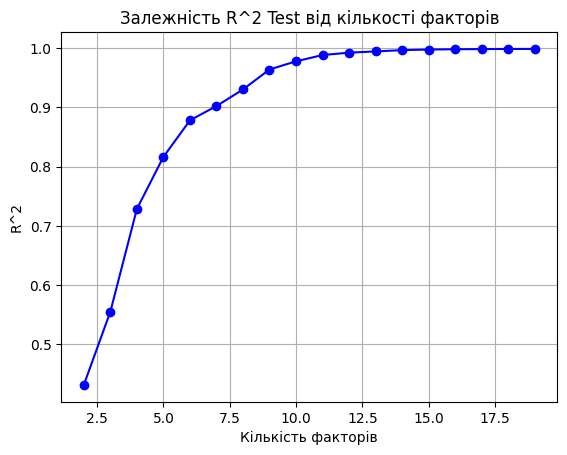

In [77]:
import matplotlib.pyplot as plt

r2 = []

for i in range(2,20):
  model = create_model(i)
  model.fit(X_test, y_test)
  y_pred= model.predict(X_test)

  r2.append((i,metrics.r2_score(y_test, y_pred)))

X, Y = zip(*r2)

plt.plot(X, Y, marker='o', linestyle='-', color='b')
plt.title('Залежність R^2 Test від кількості факторів')
plt.xlabel('Кількість факторів')
plt.ylabel('R^2')
plt.grid(True)

plt.show()

# Завдання 6
Збережіть модель

In [78]:
import joblib

file_path = 'model.pkl'

joblib.dump(model, file_path)

['model.pkl']

model2 = joblib.load(file_path)